# **Snack & Stream Planner: A ReAct-Powered AI Agent**
## Concept
An intelligent planner that pairs Netflix or other streaming show recommendations with unique snack or meal ideas
  
## **Example:**
“You’re watching Stranger Things? How about homemade Eggos or a ‘Demogorgon-themed’ milkshake?”

## **Why This Planner?**
- Combines Two Universal Passions: Merges the love for food and binge-watching to enhance user experience.
- Personalization: Utilizes the ReAct framework to make dynamic and context-aware recommendations based on user preferences and feedback.

## APIs & Steps

- **uNoGS (Unofficial Netflix API)** for show or movie data.
- **spoonacular** for recipe suggestions.

## **Flow Chart**

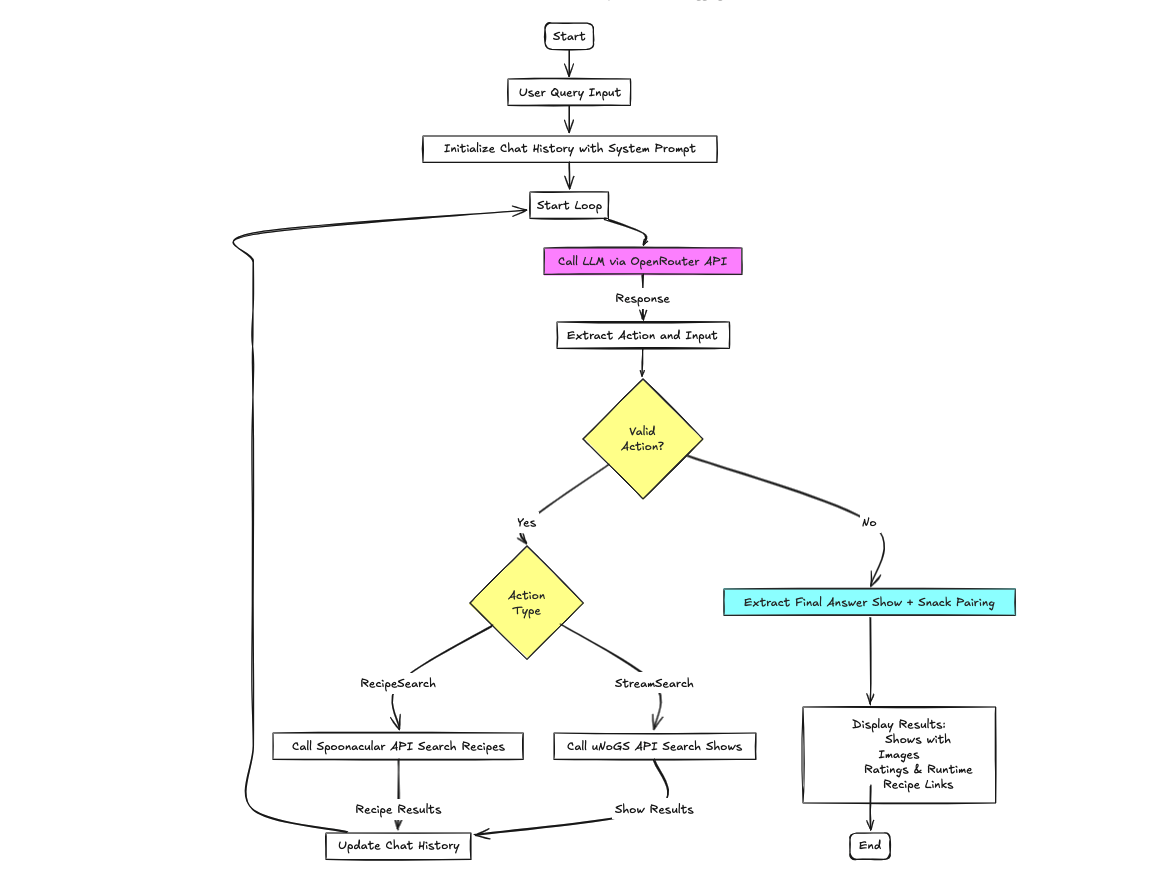

In [54]:
from typing import Dict, Any
import re
from openai import OpenAI
from google.colab import userdata
import requests
from IPython.display import Image, HTML, display

In [36]:
def extract_action_and_input(text):
  action = re.search(r"Action: (.*)", text)
  action_input = re.search(r"Action Input: (.*)", text)
  return action.group(1).strip() if action else None, action_input.group(1).strip() if action else None

In [51]:
def unogs_search(action_input: str):
    """
    Searches for Netflix content using the uNoGS API.

    Example:
        >>> result = unogs_search("horror movies")
        >>> print(result)
        {
            'shows': [
                {
                    'title': 'The Conjuring',
                    'description': 'Paranormal investigators...',
                    'watch_url': 'https://netflix.com/title/12345',
                    'image_url': 'https://...',
                    'rating': '7.5/10',
                    'type': 'movie',
                    'year': '2013'
                }
            ]
        }
    """
    url = "https://unogsng.p.rapidapi.com/search"

    headers = {
        'x-rapidapi-key': userdata.get('RAPID_API_KEY'),
        'x-rapidapi-host': "unogsng.p.rapidapi.com"
    }

    params = {
        'query': action_input,
        'limit': '5',
        'orderby': 'rating'
    }

    try:
        response = requests.get(url, headers=headers, params=params, timeout=10)
        response.raise_for_status()

        data = response.json()
        if data.get('results') and isinstance(data.get('results'), list) and len(data['results']) > 0:
            shows = []
            for show in data['results']:
                nfid = show.get('nfid')
                image_url = show.get('img') or show.get('poster')
                watch_url = f"https://www.netflix.com/title/{nfid}" if nfid else "URL not available"

                # Get both IMDb and Netflix ratings
                imdb_rating = show.get('imdbrating')
                netflix_rating = show.get('avgrating')

                # Format the rating string
                rating = []
                if imdb_rating:
                    rating.append(f"IMDb: {imdb_rating}/10")
                if netflix_rating:
                    # Convert Netflix's 5-point scale to a percentage
                    netflix_percent = round((netflix_rating / 5) * 100)
                    rating.append(f"Netflix: {netflix_percent}%")

                rating_str = " | ".join(rating) if rating else "No rating available"

                # Convert runtime from seconds to hours/minutes
                runtime_secs = show.get('runtime')
                if runtime_secs:
                    hours = runtime_secs // 3600
                    minutes = (runtime_secs % 3600) // 60
                    runtime = f"{hours}h {minutes}m" if hours else f"{minutes}m"
                else:
                    runtime = "Unknown duration"

                shows.append({
                    "title": show.get('title', 'Unknown Title'),
                    "description": show.get('synopsis', 'No description available'),
                    "watch_url": watch_url,
                    "image_url": image_url,
                    "rating": rating_str,
                    "type": show.get('vtype', 'unknown'),
                    "year": show.get('year', 'unknown'),
                    "runtime": runtime,
                    "imdb_id": show.get('imdbid')
                })

            return {
                "shows": shows,
                "query": action_input,
                "total_results": data.get('total', 0)
            }

        return {
            "error": "No results found",
            "query": action_input
        }

    except requests.exceptions.RequestException as e:
        return {
            "error": f"API request failed: {str(e)}",
            "query": action_input
        }
    except Exception as e:
        return {
            "error": f"Unexpected error: {str(e)}",
            "query": action_input
        }


In [52]:
unogs_search('comedy')

{'shows': [{'title': 'Louis C.K.: Live at the Comedy Store',
   'description': 'The comic puts his trademark hilarious/thought-provoking spin on finding a bat in his kitchen, seeing rats having sex, Boston accents and dead pets.',
   'watch_url': 'https://www.netflix.com/title/80114111',
   'image_url': 'http://occ-0-2851-38.1.nflxso.net/dnm/api/v6/evlCitJPPCVCry0BZlEFb5-QjKc/AAAABU1IbY5fP8gSbKAseRESqL2YcTvKrUwXsMgSM_DR0Fes5E3bojtfnlbsdKOizsVJzpDmaxmhJwfwZd0U3u3eTeFbTQ.jpg?r=034',
   'rating': 'IMDb: 7.8/10 | Netflix: 61%',
   'type': 'movie',
   'year': 2015,
   'runtime': '1h 5m',
   'imdb_id': 'tt4368814'},
  {'title': 'The Comedy Man',
   'description': 'After sabotaging his last gig, a struggling middle-aged actor gets one last shot at his career when he lands the leading role in several TV ads.',
   'watch_url': 'https://www.netflix.com/title/81441762',
   'image_url': 'https://occ-0-2851-41.1.nflxso.net/dnm/api/v6/oQyw8Fv9eE41UPapt7zHvdUdzrE/AAAABc1Iu6sHMN4nfiCixS4bYoN-Z4nlSzzEr

In [17]:
def get_recipe_suggestions(query: str) -> Dict[str, Any]:
    """Get recipe suggestions from Spoonacular API"""
    api_key = userdata.get('SPOONACULAR_API_KEY')
    url = f"https://api.spoonacular.com/recipes/complexSearch"

    params = {
        "apiKey": api_key,
        "query": query,
        "number": 2,
        "addRecipeInformation": True
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            recipes = data['results']
            return {
                "recipes": [{
                    "title": recipe.get('title'),
                    "url": recipe.get('sourceUrl'),
                    "readyInMinutes": recipe.get('readyInMinutes')
                } for recipe in recipes]
            }
    return {"error": "Unable to fetch recipes"}

In [18]:
get_recipe_suggestions('cheese burger')

{'recipes': [{'title': 'Everything Bagel Cheese Burger',
   'url': 'https://fullbellysisters.blogspot.com/2015/08/everything-bagel-cheese-burger.html',
   'readyInMinutes': 45},
  {'title': 'Blue Cheese Burgers',
   'url': 'https://www.foodista.com/recipe/ZVXPQHB5/blue-cheese-burgers',
   'readyInMinutes': 45}]}

In [72]:
def run_planner(user_query: str):
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=userdata.get('OPENROUTER_API_KEY'),
    )

    chat_history = [{
        "role": "system",
        "content": """
        You are a Snack & Stream Planner that suggests perfect food pairings for streaming content.
        Make your suggestions fun and creative, following this style:
        "Watching [Show Name]? How about [Creative Snack Name] ([basic recipe]) or [Another Creative Snack] ([basic recipe])!"

        You have access to these tools:
        1. StreamSearch: Search for shows/movies on streaming platforms. Returns up to 5 shows ordered by rating.
           IMPORTANT SEARCH RULES:
           - Use simple search terms without quotes
           - For genres, use: action, comedy, horror, drama, romance, thriller
           - Don't combine terms like "romantic comedy" - use "romance" or "comedy"
           - Don't use descriptive terms like "best" or "popular"

           GOOD searches:
           - horror
           - comedy
           - romance

           BAD searches:
           - "romantic comedy"
           - "best horror movies"
           - "popular shows"

        2. RecipeSearch: Search for recipes using ONLY basic, common food terms.
           GOOD recipe searches:
           - "popcorn"
           - "cookies"
           - "nachos"
           - "brownies"
           - "guacamole"

           BAD recipe searches (will fail):
           - "spooky snacks" (use "cookies" or "popcorn" instead)
           - "movie night mix" (search individual items)
           - "party platter" (too vague)

           Search one recipe at a time and be creative with presentation in the final answer.

        Use this format:
        Question: the input question you must answer
        Thought: you should always think about what to do
        Action: the action to take, should be one of [StreamSearch, RecipeSearch]
        Action Input: the input to the action (use simple terms without quotes!)
        Observation: result of the action
        Thought: analyze the results and decide next steps
        ...(Thought/Action/Observation can repeat)
        Thought: I now know what to suggest!
        Final Answer: Format your answer like this:
        "Watching [Show Title] ([Year], [Rating])? How about [Creative Snack Name] (made with [basic recipe]) or [Another Creative Snack] (using [basic recipe])!"

        Example Final Answer:
        "Watching The Conjuring (2013, IMDb: 7.5/10)? How about 'Haunted House Popcorn' (made with caramel popcorn) or 'Ghost Toast' (using garlic bread)!"
        """
    }, {
        "role": "user",
        "content": f"Question: {user_query}"
    }]

    print("\n=== Starting Snack & Stream Planner ===")
    print(f"Input Query: {user_query}")

    # Store recommended shows and recipes for final display
    recommended_shows = []
    recommended_recipes = []

    while True:
        print("\n=== Calling LLM API ===")
        completion = client.chat.completions.create(
            model="meta-llama/llama-3.2-90b-vision-instruct:free",
            messages=chat_history,
            stop=["Observation:"]
        )

        response_text = completion.choices[0].message.content
        print("\n=== LLM Response ===")
        print(response_text)

        action, action_input = extract_action_and_input(response_text)
        print("\n=== Extracted Action ===")
        print(f"Action: {action}")
        print(f"Action Input: {action_input}")

        if not action:
            print("\n=== No Valid Action Found ===")
            print("Suggesting based on thought process.")
            break

        if action == "StreamSearch":
            print("\n=== Calling StreamSearch API ===")
            result = unogs_search(action_input)
            if "shows" in result:
                print(f"Found {len(result['shows'])} shows:")
                for i, show in enumerate(result['shows'], 1):
                    print(f"\n{i}. {show['title']} ({show['year']}) - Rating: {show['rating']}")
                    print(f"Description: {show['description'][:100]}...")
                    recommended_shows.extend(result['shows'])  # Store shows for later
            else:
                print("StreamSearch Result:", result)
        elif action == "RecipeSearch":
            print("\n=== Calling RecipeSearch API ===")
            result = get_recipe_suggestions(action_input)
            if "recipes" in result:
                print(f"Found {len(result['recipes'])} recipes:")
                for i, recipe in enumerate(result['recipes'], 1):
                    print(f"\n{i}. {recipe['title']} (Prep time: {recipe['readyInMinutes']} mins)")
                    recommended_recipes.extend(result['recipes'])  # Store recipes for later
            else:
                print("RecipeSearch Result:", result)
        else:
            print("\n=== Invalid Action Detected ===")
            break

        print("\n=== Updating Chat History ===")
        chat_history.extend([
            {"role": "assistant", "content": response_text},
            {"role": "user", "content": f"Observation: {result}"}
        ])
        print("Chat History Length:", len(chat_history))

    print("\n=== Final Response ===")
    print(response_text)

    # Extract show titles from final answer
    final_answer = response_text.split("Final Answer:")[-1].strip()

    # Display only the shows mentioned in final answer
    print("\n=== Your Personalized Streaming & Snack Suggestion ===")

    # Use a set to track shown items
    shown_shows = set()

    for show in recommended_shows:
        # Check if this show's title appears in the final answer and hasn't been shown yet
        if show['title'].lower() in final_answer.lower() and show['title'] not in shown_shows:
            shown_shows.add(show['title'])
            print("\n" + "="*50)
            print(f"📺 {show['title']} ({show['year']})")
            print(f"⭐ {show['rating']}")
            print(f"⏱️ {show['runtime']}")
            print(f"📝 {show['description']}")
            print(f"🔗 Watch here: {show['watch_url']}")
            print("="*50)

            # Display show image if available
            if show.get('image_url'):
                try:
                    display(Image(url=show['image_url']))
                except Exception as e:
                    print(f"Could not load image: {e}")

    # Use a set for recipes too
    shown_recipes = set()
    for recipe in recommended_recipes:
        if recipe['title'].lower() in final_answer.lower() and recipe['title'] not in shown_recipes:
            shown_recipes.add(recipe['title'])
            print(f"\n🍳 {recipe['title']}")
            print(f"⏱️ Preparation time: {recipe['readyInMinutes']} minutes")
            if recipe.get('url'):
                display(HTML(f'<a href="{recipe["url"]}" target="_blank">👩‍🍳 View Full Recipe</a>'))

    return response_text

In [70]:
query = "I want to watch something scary with appropriate snacks"
result = run_planner(query)
print("\nResult:", result)


=== Starting Snack & Stream Planner ===
Input Query: I want to watch something scary with appropriate snacks

=== Calling LLM API ===

=== LLM Response ===
Thought: To find a scary show/movie and pair it with fitting snacks, I should start by searching for a streaming title. Since the query is quite broad, I'll analyze the search results to pick a title.

Action: StreamSearch
Action Input: horror



=== Extracted Action ===
Action: StreamSearch
Action Input: horror

=== Calling StreamSearch API ===
Found 5 shows:

1. Hogwood: A Modern Horror Story (2020) - Rating: IMDb: 8.3/10
Description: Exposing the jarring conditions inside one of Britain&#39;s largest pig farms, an activist group cal...

2. Circus of Horrors (1960) - Rating: IMDb: 6.1/10
Description: After mutilating a patient, a plastic surgeon is booted from the medical profession and goes into hi...

3. Horrors of the Black Museum (1959) - Rating: IMDb: 5.9/10
Description: In order to gather material for his stories, a twisted


📺 Two Sentence Horror Stories (2019)
⭐ IMDb: 5.5/10
⏱️ Unknown duration
📝 This anthology series of terror features diverse characters facing primal fears in spine-chilling situations that stretch past daily routine.
🔗 Watch here: https://www.netflix.com/title/80244627



🍳 Apple-Infused Caramel Corn
⏱️ Preparation time: 45 minutes



🍳 Pistachio Milk Chocolate Chip Cookies
⏱️ Preparation time: 45 minutes



Result: Thought: I've received a search result for Pistachio Milk Chocolate Chip Cookies, which I can use as a fitting snack for a scary show. With the Apple-Infused Caramel Corn and Pistachio Milk Chocolate Chip Cookies, I now have two creative snack options to pair with a scary show.

Thought: I now know what to suggest. 

Final Answer: "Watching Hogwood: A Modern Horror Story (2020, IMDb: 8.3/10) or Two Sentence Horror Stories (2019, IMDb: 5.5/10)? How about 'Horror Flicks Caramel Crunch' (made with apple-infused caramel corn) or 'Scary Movie Bites' (using pistachio milk chocolate chip cookies)!"


In [73]:
query = "Suggest a romantic comedy and date night snacks"
result = run_planner(query)
print("\nResult:", result)


=== Starting Snack & Stream Planner ===
Input Query: Suggest a romantic comedy and date night snacks

=== Calling LLM API ===

=== LLM Response ===
Thought: To suggest a romantic comedy and date night snacks, I first need to find a popular romantic comedy.

Action: StreamSearch
Action Input: romance



=== Extracted Action ===
Action: StreamSearch
Action Input: romance

=== Calling StreamSearch API ===
Found 5 shows:

1. Romance is a bonus book (2019) - Rating: IMDb: 8.1/10
Description: A gifted writer who&#39;s the youngest editor-in-chief ever at his publishing company gets enmeshed ...

2. The Romance of Tiger and Rose (2020) - Rating: IMDb: 7.9/10
Description: When a screenwriter wakes up as a princess in the historical drama she&#39;s penning, she must maneu...

3. Delicious Romance (2023) - Rating: IMDb: 7.9/10
Description: In a bustling city, three close friends try to navigate their career and relationships as a series o...

4. A Moment of Romance (1990) - Rating: IMDb: 7.4/10


🍳 Dairy Free Chocolate Truffles
⏱️ Preparation time: 45 minutes



🍳 Walnut Dark Chocolate Truffles
⏱️ Preparation time: 30 minutes



Result: Thought: I found two recipes for chocolate truffles. This is a great dessert for a date night, so I'll use this as my snack suggestion.

Thought: Now that I have a show title and a snack idea, I can create a final response.

Final Answer: Watching Romance is a bonus book (2019, IMDb: 8.1/10)? How about 'Love Story Truffles' (made with dairy free chocolate truffles) or 'Sweetheart Bites' (using walnut dark chocolate truffles)!
